In [1]:
""" LEVEL 1 QC: Remove bottom, large error velocity and upward velocity from the merged raw-ADCP data
"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from convert_time import datetime_to_yearday
from bipolar import bipolar

In [7]:
### Specify merged Saildrone merged adcp nc file
year = '2023'
platf_num = '1045'
path_adcp = '/Users/chi/Documents/projects/sd-ni-wp/data_manipulate/data_merge_adcp/'

### load adcp data
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc')
time = ds_adcp.variables['time'][:]
dtime_cur_SD = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=time[i]) for i in range(len(time))])
timestamp_cur_SD = np.array([dtime_cur_SD[i].timestamp() for i in range(len(dtime_cur_SD))])
_, yday_cur_SD = datetime_to_yearday( dtime_cur_SD )
vars_str = ['longitude','latitude','depth','vel_east','vel_north','depth','error_vel','vel_up','echo_intensity','percent_good_4_beam','correlation']
for i in range( len(vars_str) ):
    temp = ds_adcp.variables[vars_str[i]][:]
    temp.filled(np.nan)
    if 'vel' in vars_str[i]:
        temp = 100*temp # convert velocity unit from m/s to cm/s
    exec( vars_str[i]+' = temp')
ds_adcp.close()    
del time
print(year+' SD-'+platf_num+' time:',dtime_cur_SD[0],'~',dtime_cur_SD[-1])
dz_add = 6-depth[0]
depth = depth+dz_add
print(depth)

2023 SD-1045 time: 2023-07-16 00:00:00 ~ 2023-11-01 23:55:00
[  6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.  32.
  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.  58.  60.
  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.  88.
  90.  92.  94.  96.  98. 100. 102. 104.]


In [23]:
### change the time limits
print('time limit of this nc file',dtime_cur_SD[0],dtime_cur_SD[-1])
tlim_plot = [datetime.datetime(int(year),7,16), datetime.datetime(int(year),11,1)]
nt_plot = int((tlim_plot[1]-tlim_plot[0]).days)
tticks = [tlim_plot[0]+datetime.timedelta(days=i) for i in range(nt_plot)]
tticks_label = [tticks[i].strftime('%m/%d') for i in range(len(tticks))]
print(tticks_label)

time limit of this nc file 2023-07-16 00:00:00 2023-11-01 23:55:00
['07/16', '07/17', '07/18', '07/19', '07/20', '07/21', '07/22', '07/23', '07/24', '07/25', '07/26', '07/27', '07/28', '07/29', '07/30', '07/31', '08/01', '08/02', '08/03', '08/04', '08/05', '08/06', '08/07', '08/08', '08/09', '08/10', '08/11', '08/12', '08/13', '08/14', '08/15', '08/16', '08/17', '08/18', '08/19', '08/20', '08/21', '08/22', '08/23', '08/24', '08/25', '08/26', '08/27', '08/28', '08/29', '08/30', '08/31', '09/01', '09/02', '09/03', '09/04', '09/05', '09/06', '09/07', '09/08', '09/09', '09/10', '09/11', '09/12', '09/13', '09/14', '09/15', '09/16', '09/17', '09/18', '09/19', '09/20', '09/21', '09/22', '09/23', '09/24', '09/25', '09/26', '09/27', '09/28', '09/29', '09/30', '10/01', '10/02', '10/03', '10/04', '10/05', '10/06', '10/07', '10/08', '10/09', '10/10', '10/11', '10/12', '10/13', '10/14', '10/15', '10/16', '10/17', '10/18', '10/19', '10/20', '10/21', '10/22', '10/23', '10/24', '10/25', '10/26', '10/2

In [ ]:
### create indices of OK data ###
### Might have to play with the numbers below for each drone
dz = 2
nbeam = 4
grad_echo_max_detect_bottom = -10
# grad_max_shallow_water = -10
# z_shallow_water = 20
cri_min_echo = 40
cri_max_echo = 140
cri_min_perc_good = 80
cri_min_corr = 90
''' 
0: pass test - "good data"
1: bottom 
2: weak echo
3: strong echo
4: low percent good
5: low correlation
'''
str_flags_vel = ['PASS','bottom','weak echo','strong echo','low percent good','low correlation']
str_flags = [str(i) for i in range(len(str_flags_vel))]
str_flags_cri = ['',\
                 'gradecho<{:.1f}'.format(grad_echo_max_detect_bottom),\
                 'echo<{:.1f}'.format(cri_min_echo),\
                    'echo>{:.1f}'.format(cri_max_echo),\
                    '75 percentile of percent_good_4_beam<{:.1f}'.format(cri_min_perc_good),\
                    'correlation<{:.2f}'.format(cri_min_corr)]
print(str_flags_cri)
print([a+': '+b+'('+c+')' for a,b,c in zip(str_flags,str_flags_vel,str_flags_cri)])
### QC: use d(echo_intensity)/dz. echo intensity, percent_good_4_beam, correlation to flag data
iOK_QC = np.ones( vel_east.shape, dtype='bool')
iOK_QC[:,:] = True
iflag = np.zeros(vel_east.shape, dtype=int) 
for i in range( len(dtime_cur_SD) ):
    for z in range( len(depth)-1 ):
        ### (1) echo intensity
        if np.mean(echo_intensity[i,:,z]) < cri_min_echo:
            iOK_QC[i,z] = False
            iflag[i,z] = 2
        if np.mean(echo_intensity[i,:,z]) > cri_max_echo:
            iOK_QC[i,z] = False
            iflag[i,z] = 3
        grad_echo = (echo_intensity[i,:,z]-echo_intensity[i,:,z+1])/dz
        if np.mean(grad_echo)< grad_echo_max_detect_bottom:
            iOK_QC[i,z+1:] = False
            iflag[i,z+1:] = 1
            break
        ### (2) percent_good_4_beam
        if percent_good_4_beam[i,z]< cri_min_perc_good:
            iOK_QC[i,z] = False
            iflag[i,z] = 4
        ### (3) correlation - if the 75 percentile
        if np.percentile(correlation[i,:,z],75)< cri_min_corr:
            iOK_QC[i,z] = False
            iflag[i,z] = 5

['', 'gradecho<-10.0', 'echo<40.0', 'echo>140.0', 'w>80.0', 'r(errvel)>90.00']
['0: PASS()', '1: bottom(gradecho<-10.0)', '2: weak echo(echo<40.0)', '3: strong echo(echo>140.0)', '4: low percent good(w>80.0)', '5: low correlation(r(errvel)>90.00)']


In [10]:
str_flags_cri = ['',\
                 'gradecho<{:.1f}'.format(grad_echo_max_detect_bottom),\
                 'echo<{:.1f}'.format(cri_min_echo),\
                    'echo>{:.1f}'.format(cri_max_echo),\
                    '75 percentile of percent_good_4_beam<{:.1f}'.format(cri_min_perc_good),\
                    'correlation<{:.2f}'.format(cri_min_corr)]
print(str_flags_cri)

['', 'gradecho<-10.0', 'echo<40.0', 'echo>140.0', '75 percentile of percent_good_4_beam<80.0', 'correlation<90.00']


echo<90_>140_gradecho<-10_perc4beam<80.0_corr<90.00
[<matplotlib.colors.LinearSegmentedColormap object at 0x7fbe9084d7c0>, <matplotlib.colors.LinearSegmentedColormap object at 0x7fbe9084d7c0>, <matplotlib.colors.LinearSegmentedColormap object at 0x7fbe9084d7c0>, <matplotlib.colors.LinearSegmentedColormap object at 0x7fbe9084d7c0>, 'nipy_spectral', 'jet']


<Figure size 432x288 with 0 Axes>

<Figure size 1296x936 with 0 Axes>

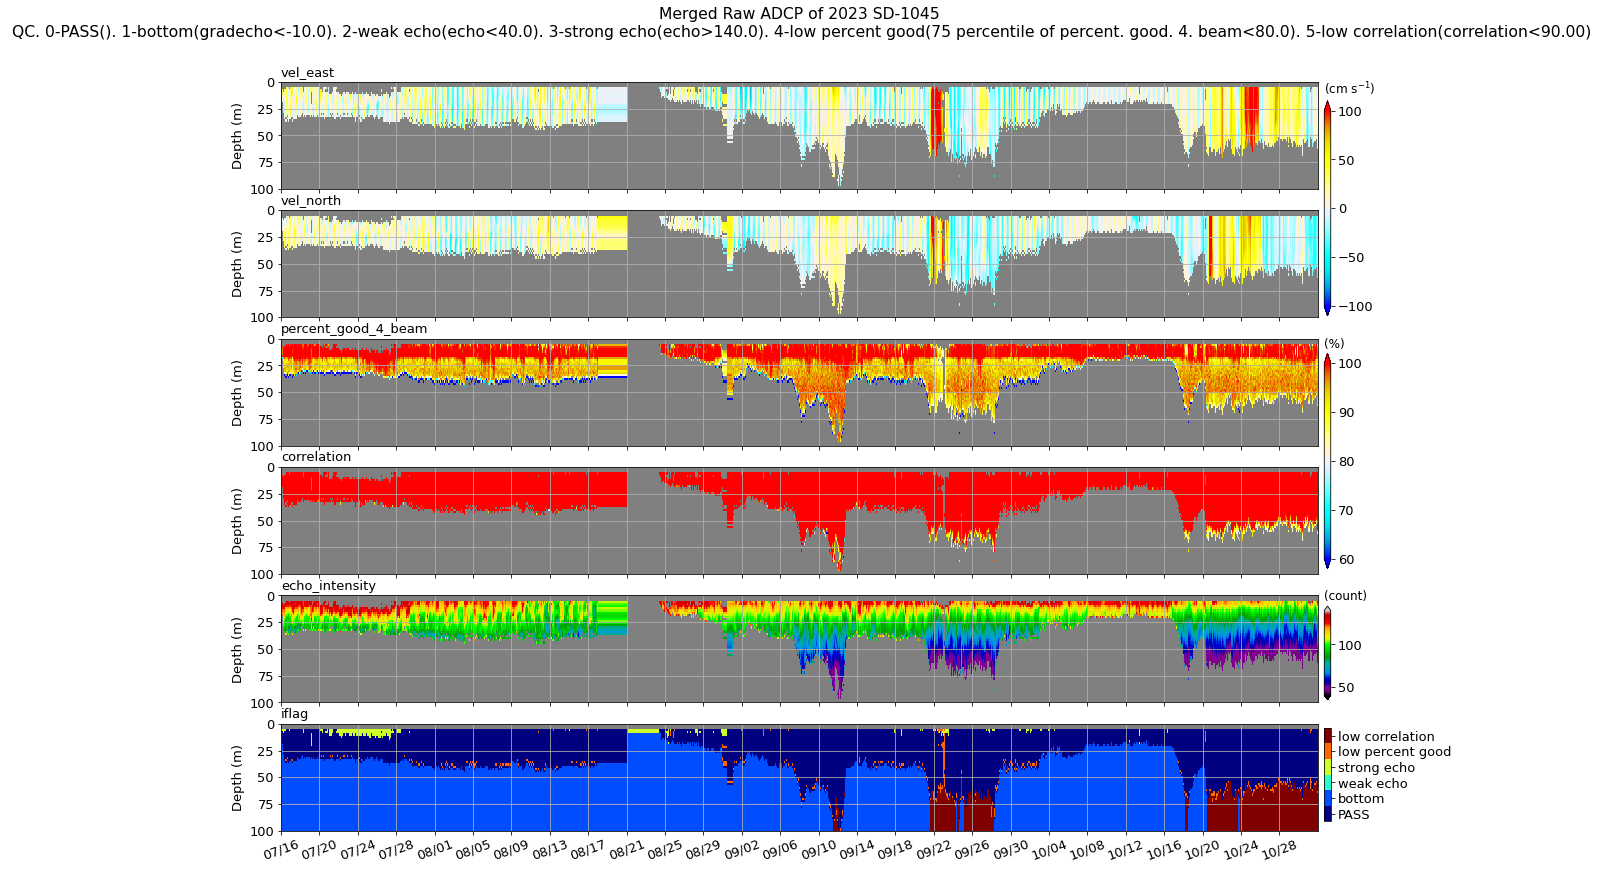

In [25]:
### plot (1) Before and (2) After QC's : u, v, w, error_vel, 1 beam of echo_intensity
isQC = [False, True]
str_QC_crit = 'echo<{:.0f}_>{:.0f}_gradecho<{:.0f}_perc4beam<{:.1f}_corr<{:.2f}'\
    .format(cri_min_corr,cri_max_echo,grad_echo_max_detect_bottom,cri_min_perc_good,cri_min_corr)
print(str_QC_crit)
vars_str = ['vel_east','vel_north','percent_good_4_beam','correlation','echo_intensity','iflag']
vars_unit_str = ['(cm s$^{-1}$)','(cm s$^{-1}$)','(%)','','(count)',''] 
vellim = [[-100,100],[-100,100],[60,100],[60,100],[cri_min_echo,cri_max_echo],[0,5]]
cm_vel = bipolar(neutral=0.95)
cmap = [cm_vel,cm_vel,cm_vel,cm_vel,'nipy_spectral','jet']
print(cmap)
nrow = len(vars_str)
y0_cb = [0.65,0.38,0.24,0.11]
dy_cb = [0.23,0.23,0.1,0.1]
nflags = len(str_flags_vel) # including no flag
###
for iplot in isQC:
    plt.clf()
    fig, ax = plt.subplots(nrows=nrow)
    plt.gcf().set_size_inches(18, 13)
    plt.rcParams.update({'font.size': 13})
    icb = 0
    for i in range( nrow ):
        plt.subplot(nrow,1,i+1)
        ### load variable to plot
        if ('echo' in vars_str[i]) | ('corr' in vars_str[i]):
            var_plot = eval(vars_str[i])[:,0,:].copy()
        else:
            var_plot = eval(vars_str[i]).copy()
        ### flag the data
        if iplot:
            str_QC = 'QC_'+'_'.join([a+'-'+b+'('+c+')' for a,b,c in zip(str_flags,str_flags_vel,str_flags_cri)])
            if 'flag' not in vars_str[i]:
                var_plot[~iOK_QC] = np.nan
        else:
            str_QC = ''
        if 'flag' not in vars_str[i]:
            cs = plt.pcolormesh(dtime_cur_SD, depth, var_plot.transpose(), cmap=cmap[i],\
                            vmin=vellim[i][0],vmax=vellim[i][1],label=vars_str[i])
        else:
            cmap_flag = plt.get_cmap(cmap[i], nflags)
            cs = plt.pcolormesh(dtime_cur_SD, depth, var_plot.transpose(), cmap=cmap_flag,\
                            vmin=-0.5,vmax=5.5,label=vars_str[i])
        ### figure setting
        plt.xticks(tticks[::4],rotation=0) ### change 
        if i == nrow-1:
            plt.gca().set_xticklabels(tticks_label[::4],rotation=20) ### change
        else:
            plt.gca().set_xticklabels('')
        plt.xlim(tlim_plot)
        plt.ylim([0,100])
        plt.gca().invert_yaxis()
        plt.grid()
        plt.ylabel('Depth (m)')
        plt.title(vars_str[i],loc='left',fontsize=13)
        plt.gca().set_facecolor('gray')
        ### add colorbar
        if (i == 0) | (i == 2) | (i == 4) :
            cbar_ax = fig.add_axes([.905,y0_cb[icb],.005,dy_cb[icb]])
            axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,extend='both')
            cbar_ax.set_title(vars_unit_str[i],y=1.05,loc='left',fontsize=12)
            icb = icb + 1
        if i == 5: # flag's colorbar
            cbar_ax = fig.add_axes([.905,y0_cb[icb],.005,dy_cb[icb]])
            axf = plt.colorbar(cs,orientation='vertical',cax=cbar_ax,ticks=np.arange(0,nflags))
            cbar_ax.set_title(vars_unit_str[i],y=1.05,loc='left',fontsize=12)
            cbar_ax.set_yticks(np.arange(0,nflags))
            cbar_ax.set_yticklabels(str_flags_vel)
        
    ###
    plt.suptitle('Merged Raw ADCP of '+year+' SD-'+platf_num+'\n '+str_QC.replace('_','. '))
    plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.2)
    ### save to figure
    plt.savefig('time-depth_uv_perc-good_corr_echoint_SD'+platf_num+str_QC+'_'+\
                tlim_plot[0].strftime('%Y%m%d-')+tlim_plot[1].strftime('%m%d')+'.png',dpi=400,bbox_inches='tight')
    # break

In [19]:
n = len(iflag.flatten())
for i, flag in enumerate(str_flags_vel):
    icount = np.sum(iflag.flatten() == i)
    print('{:.2f}% of data '.format(icount/n*100)+flag)
    if i == 0:
        icount_nan = np.sum((np.isnan(vel_east.flatten())) & (iflag.flatten()== i))
        icount_notnan = np.sum((~np.isnan(vel_east.flatten())) & (iflag.flatten()== i))
        # print(icount_nan, icount_notnan, icount, icount_nan+icount_notnan)
        print('of which {:.2f}% of '.format(icount_nan/icount*100)+flag+' data is NaN')

35.88% of data PASS
of which 1.04% of PASS data is NaN
54.83% of data bottom
0.00% of data weak echo
0.60% of data strong echo
1.05% of data low percent good
7.64% of data low correlation


In [20]:
### append data flags (integers) that has the same size to the merged raw adcp file. 
ds_adcp = nc.Dataset(path_adcp+'adcp-raw-merge-'+year+'-SD'+platf_num+'.nc','r+',format='NETCDF4')
all_exist_varnms_in_nc = ds_adcp.variables ### this is a dictionary
varnm = 'data_flag'
if varnm not in all_exist_varnms_in_nc.keys():
    print('The existing nc file content:')
    print(ds_adcp)
    ### append new variable
    data_flag = ds_adcp.createVariable(varnm, np.float64, ('time','depth'))
    data_flag.long_name = 'data flags'
    data_flag.units = ''
    data_flag.comment = 'QC: '+'. '.join([a+'-'+b+'('+c+')' for a,b,c in zip(str_flags,str_flags_vel,str_flags_cri)])
    ### writing data to the existing nc file
    data_flag[:,:] = iflag
    print('==========')
    print('The new nc file after appending data to it.')
    print(ds_adcp)
else:
    print('==========')
    print('variable already exists so replace/update the variable ('+varnm+'). ')
    ### update variable
    ds_adcp[varnm][:] = iflag
    print('The updated nc file after updating the variable ('+varnm+').')
    print(ds_adcp)

ds_adcp.close()

The existing nc file content:
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2023 SD-1045
    subtitle: Only selected variables for adcp measurements are here. Temporal resolution is ~10-minute.
    dimensions(sizes): depth(50), time(28325), beam(4)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 longitude(time), float64 latitude(time), float64 pitch(time), float64 roll(time), float64 heading(time), float64 vehicle_vel_east(time), float64 vehicle_vel_north(time), float64 vehicle_vel_up(time), float64 bt_vel_east(time), float64 bt_vel_north(time), float64 bt_vel_up(time), float64 vel_east(time, depth), float64 vel_north(time, depth), float64 vel_up(time, depth), float64 error_vel(time, depth), float64 percent_good_4_beam(time, depth), float64 percent_good_3_beam(time, depth), float64 percent_good(time, depth), float64 bt_range(time, beam), float64 bt_cor(time, beam), float64 bt_amp(ti